# Learning Discrete-Time Estimation and Control with Transformers

In [16]:
from kalman_filter import *
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

from utils import *
from trajectories import *

CUT = 5 # cutoff the first few datapoints because they have too much noise so it is not a fair comparison.
T = 250 # how long to simulate the trajectory # 100
num_traj_train = 100; num_traj_test = 20
num_traj = num_traj_train + num_traj_test

# State Estimation: Continuous State Space 

Dynamical System:

$\vec{x}_{t+1} = A\vec{x}_t + B \vec{u}_t + \vec{w}_t$ is the Transition Model, where $\vec{w}_t \sim \mathcal{N}(\vec{0}, Q)$ is process noise

$\vec{y}_t = C\vec{x}_t + \vec{v}_t$ is Observation Model, where $\vec{v}_t \sim \mathcal{N}(\vec{0}, R)$ is sensor noise

## Generate Trajectories

In [17]:
task_name = 'spring_mass_damper' # Choose from 'circular', 'motion', 'so3', 'accel', 'spring_mass_damper'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]

u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq, state_dim, input_dim, obs_dim)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

Trajectory shape (250, 2)
Measured shape (250, 1)


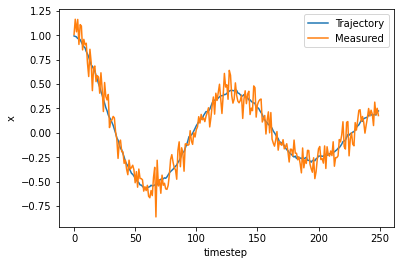

In [18]:
# plot a sample trajectory and noisy measurements
plot({'Trajectory': traj[0], 'Measured': meas[0]})

## 0. Optimization Based Approach using known A, B, C to get best possible fit

## 1. Kalman Filtering using known A, B, C to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

In [26]:
kfiltered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kfiltered[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr = np.linalg.norm(kfiltered - traj)**2 / num_traj / T
    
print("Average Squared Error:", err_fltr)

Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
Converged in 77 iterations
C

Trajectory shape (250, 2)
Measured shape (250, 1)
Filtered shape (250, 2)


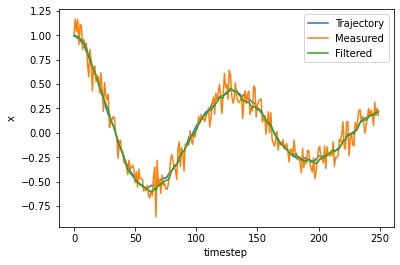

In [27]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered[0]})

### 1b. Kalman Filter with pure steady state gains

In [28]:
kfiltered_ss = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kinematics_forward.run_till_ss()
    kfiltered_ss[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr_ss = np.linalg.norm(kfiltered_ss - traj)**2 / num_traj / T

print("Average Squared Error", err_fltr_ss)

Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in

Trajectory shape (250, 2)
Measured shape (250, 1)
Filtered shape (250, 2)


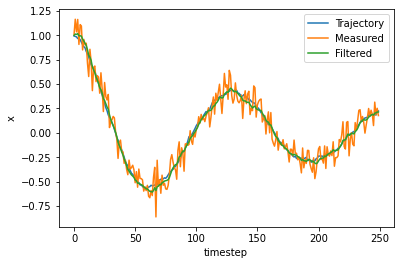

In [29]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered_ss[0]})

### 1c. Kalman Smoothing with Reverse Kalman Filter

## 2. Least Squares System ID + Kalman Filtering

###  2a Update on the identified system at each timestep
The following cell takes about 40 seconds to run.

Note - The System Identification as implemented currently requires the state dimension to match the obs dimension.

In [ ]:
id_filtered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    # Use the same data as before, but now no peeking on what are the actual A, B matrices
    A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
    kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
    id_fltr = np.zeros(shape=(T,state_dim))
    
    for t in range(T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics.A = A_found
        kinematics.B = B_found
        kinematics.predict(u_seq[i][t])
        kinematics.update(meas[i][t])
        id_fltr[t] = kinematics.state
    id_filtered[i] = id_fltr
    
err_id_fltr = np.linalg.norm(id_filtered[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr)

In [ ]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': id_filtered[0]})

### 2b Kalman filter for each timestep simulated from the start

The cell below takes about 5 minutes to run.

In [ ]:
err_id_fltr_sim = 0
id_filtered_simulated = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    id_fltr_sim = np.zeros(shape=(T,state_dim))
    for t in range(1, T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics = KFilter(A_found, B_found, C, Q, R, x0)
        id_fltr_sim[t] = kinematics.simulate(meas[i, :t], u_seq[i, :t])[-1]
    id_filtered_simulated[i] = id_fltr_sim
    
err_id_fltr_sim = np.linalg.norm(id_filtered_simulated[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr_sim)

In [ ]:
plot({"Trajectory:": traj[0], "ID + Filtered": id_filtered_simulated[0]})

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 

The following cell takes around 20 minutes per trajectory that you want to fit your KF on. In general, it is easiest to just train it on one.

In [11]:
err_learned_kf = 0
learned_kfs = []
learned_kfs_simulated = np.zeros(shape=(num_traj, T, state_dim))

if True:
    i = 0
# for i in range(num_traj_train, num_traj):
    kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
    kinematics.fit(meas[i], u_seq[i], eps=2, maxIt=15000)
    learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
    learned_kfs_simulated[i] = learned_kf_sim
    learned_kfs.append(kinematics)

    plt.figure()
    plt.plot(kinematics.losses[30:])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()

    err_learned_kf = np.linalg.norm(learned_kf_sim[CUT:, :] - traj[i,CUT:, :])**2

print("Average Squared Error", err_learned_kf / T) #num_traj_test / T)

Iteration 1000 : Loss 10.082481001801952
Iteration 2000 : Loss 6.5121326512830136


KeyboardInterrupt: 

Trajectory shape (250, 2)
Measured shape (250, 1)
Optimal KF shape (250, 2)
Learned KF simulated shape (250, 2)


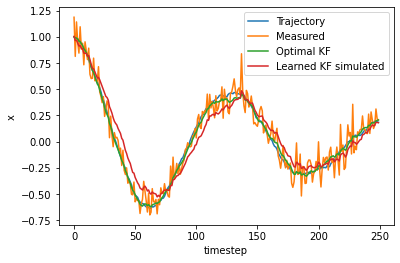

In [12]:
learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
learned_kfs_simulated[i] = learned_kf_sim
learned_kfs.append(kinematics)
plot({'Trajectory': traj[0], "Measured":meas[0], "Optimal KF": kfiltered[0], "Learned KF simulated": learned_kfs_simulated[0]})

In [ ]:
# The cell below is useful to compare the LearnedKF parameters to true parameters of the Kalman Filter
# learned_kf = learned_kfs[0]
# true_kf = KFilter(A, B, C, Q, R, state=x0)
# true_kf.run_till_ss()
# print("Aprime true is", A - A @ true_kf.K @ true_kf.C)
# print("Aprime learned is", learned_kf.Aprime)
# print("Bprime true is", B)
# print("Bprime learned is", learned_kf.Bprime)
# print("Gprime true is", A @ true_kf.K)
# print("Gprime learned is", learned_kf.Gprime)
# print("Cprime true is", C)
# print("Cprime learned is", learned_kf.Cprime)

## ZOH Baseline 
Quantify the error if we just predict the previous token (identity map) - ie. no learning involved

In [13]:
error = 0
for i in range(num_traj):
    for t in range(1,T):
        error += np.linalg.norm(meas[i, t] - meas[i, t-1])**2
print("Error is", error / num_traj / T)

Error is 0.021080408080118143


# Transformer-based techniques to learn the dynamics and filter the position

In [38]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 36 # use 36-dimensional embedding for now
batch_size = 10

In [39]:
# Training Data
indices_train = np.arange(num_traj_train)
np.random.shuffle(indices_train)

# The input to the model will be a concatenation of the current measured state and the "u" input at this timestep
target_sequences_train = torch.from_numpy(meas)[indices_train,:,:]
input_sequences_train = torch.from_numpy(u_seq)[indices_train,:,:]
transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
true_positions_train = torch.from_numpy(traj)[indices_train,:,:]


# Test Data
indices_test = np.arange(num_traj_train, num_traj)
traj_test = traj[indices_test,:,:]
meas_test = meas[indices_test,:,:]
target_sequences_test = torch.from_numpy(meas)[indices_test,:,:]
input_sequences_test = torch.from_numpy(u_seq)[indices_test,:,:]
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)
true_positions_test = torch.from_numpy(traj)[indices_test,:,:]

## GPT-style: Transformer Decoder only for Autoregressive generation

The following cell takes around 15 minutes to run.

In [40]:
num_epochs = 200

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=obs_dim,
                n_layers=3, n_heads=6, d_filter=256, dropout=None).to(device)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_epochs):
    for batchNum in range(num_traj_train // batch_size):
        
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]  #TRYING TO HIT NOISY DATA
        
        decoder_output = gpt_model(transformer_input_batch, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)
            
        loss = loss_func(decoder_output, target_sequence_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 211.78519375104673
Epoch 1 : Loss 149.13403770772072
Epoch 2 : Loss 64.07538968367915
Epoch 3 : Loss 50.71982253379212
Epoch 4 : Loss 45.564257340061395
Epoch 5 : Loss 40.13899547699725
Epoch 6 : Loss 40.09604727620567
Epoch 7 : Loss 38.84031475381555
Epoch 8 : Loss 38.55026022819096
Epoch 9 : Loss 38.27635582230266
Epoch 10 : Loss 37.98014238406238
Epoch 11 : Loss 37.879047959406115
Epoch 12 : Loss 37.7778524925621
Epoch 13 : Loss 37.744293475407744
Epoch 14 : Loss 37.68333450993126
Epoch 15 : Loss 37.59832275360785
Epoch 16 : Loss 37.46790887302727
Epoch 17 : Loss 37.33596190373159
Epoch 18 : Loss 37.23209740550775
Epoch 19 : Loss 37.15806314817348
Epoch 20 : Loss 37.10258583769431
Epoch 21 : Loss 37.04791556592535
Epoch 22 : Loss 36.995423699697966
Epoch 23 : Loss 36.94949396607436
Epoch 24 : Loss 36.90720209433678
Epoch 25 : Loss 36.869531899474836
Epoch 26 : Loss 36.83435332942257
Epoch 27 : Loss 36.7974219498557
Epoch 28 : Loss 36.767726548542726
Epoch 29 : Loss 36

KeyboardInterrupt: 

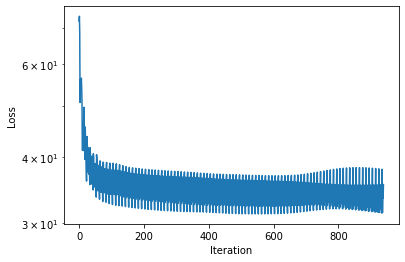

In [43]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

Trajectory shape (250, 2)
Measured shape (250, 1)
Filtered by GPT shape (250, 1)
Optimal KF shape (250, 2)


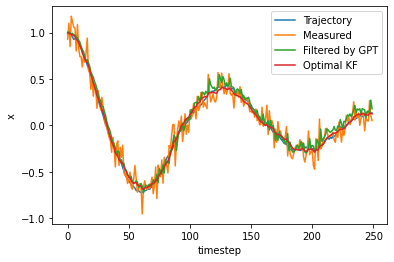

Average Squared Error between traj and meas 0.395412476944303
Average Squared Error of filtered vs traj 0.3841465487692301
Average Squared Error between filtered and meas 0.013949687194007916


In [47]:
gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

# Index that we want to visualize from the test indices
i = 3 # index to visualize (0 through 19)

filtered = gpt_transformer_sim.detach().numpy()

plot({"Trajectory": traj_test[i], "Measured": meas_test[i], "Filtered by GPT":filtered[i], "Optimal KF":kfiltered[i + num_traj_train]})

print('Average Squared Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / num_traj_test / T)
print('Average Squared Error of filtered vs traj', np.linalg.norm(filtered - traj_test)**2 / num_traj_test / T)
print('Average Squared Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / num_traj_test / T)

## BERT-style: Transformer Encoder only, fill in trajectory

Note - we are taking advantage of the ground truth (TRUE TRAJECTORY) here! 
The following cell takes about 15 minutes to run.

In [45]:
num_epochs = 200
# p = 0.15 # probability of zeroing out a token

bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
                embed_size=embed_dim, output_size=state_dim, # trying to hit the actual state (not the observation)
                n_layers=4, n_heads=6, d_filter=64, 
                dropout=None)
optimizer = torch.optim.Adam(bert_model.parameters())

loss_func = torch.nn.MSELoss(reduction='sum')
# losses = []

for i in range(num_epochs):
    for batchNum in range(num_traj_train // batch_size):
        
        # Randomly zero-out p% of the tokens in transformer_input_train - different for each batch each time
        # If we're trying to hit the true targets, DO NOT MASK!
        # mask = torch.bernoulli( (1-p) * torch.ones(size=(batch_size, T) ) )
        # mask = mask.repeat(obs_dim+input_dim, 1, 1).permute(1, 2, 0)
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :] # * mask
     
        # Do not even use the mask at all. Instead, just try to hit true targets. 
        # FIX THIS
        
        # transformer_input_batch has shape [batch_size, seq_len, (obs_dim+input_dim)] 
        
        true_positions_batch = true_positions_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]        
        encoder_output = bert_model(transformer_input_batch, encoder_mask=None)

        loss = loss_func(encoder_output, true_positions_batch) #,target_sequences_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 660.9425762338324
Epoch 1 : Loss 254.89333316424052
Epoch 2 : Loss 135.38732434223903
Epoch 3 : Loss 84.76844673041322
Epoch 4 : Loss 68.54546590252988
Epoch 5 : Loss 57.32067689479815
Epoch 6 : Loss 48.281570037884734
Epoch 7 : Loss 44.220761978762155
Epoch 8 : Loss 41.700736775420225
Epoch 9 : Loss 40.30750496821949
Epoch 10 : Loss 38.98180632668904
Epoch 11 : Loss 38.07441651195595
Epoch 12 : Loss 37.40623745605631
Epoch 13 : Loss 36.77238013484411
Epoch 14 : Loss 36.299082424472964
Epoch 15 : Loss 35.81058646255914
Epoch 16 : Loss 35.382821595626304
Epoch 17 : Loss 34.98516426044147
Epoch 18 : Loss 34.650638713081804
Epoch 19 : Loss 34.369557982737774
Epoch 20 : Loss 34.15208039051162
Epoch 21 : Loss 33.97866481682922
Epoch 22 : Loss 33.832200926953675
Epoch 23 : Loss 33.70073902307617
Epoch 24 : Loss 33.58972989481075
Epoch 25 : Loss 33.47151577633967
Epoch 26 : Loss 33.37104735196104
Epoch 27 : Loss 33.27508528369719
Epoch 28 : Loss 33.17804539605508
Epoch 29 : Los

In [ ]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [ ]:
bert_transformer_sim = bert_model(transformer_input_test, encoder_mask=None)

# Index that we want to visualize from the test indices
i = 0

filtered = bert_transformer_sim.detach().numpy()

plot({"Trajectory": traj_test[i], "Measured":meas_test[i], "Filtered":filtered[i], "Optimal KF":kfiltered[i + num_traj_train]})

print('Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / num_traj_test / T)
print('Average Squared Error of BERT', np.linalg.norm(filtered - traj_test)**2 / num_traj_test / T)
print('Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / num_traj_test / T)